In [1]:
#Importing the created transformer
import transformer_model

#manipulation
import numpy as np
import random
import pandas as pd
import torch

#trainer
import torch.nn as nn
import torch.optim as optim

#visualization
import matplotlib.pyplot as plt

#importing data
import pickle

#Device set to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/home/mihriban/gf_transformer/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Importing data 
Depending on the preference the chosen data can be loaded to the device

In [3]:
#Importing processed PISCES data
pisces_angles = torch.load('data_processed/pisces_training/angles.pt')
pisces_embeddings = torch.load('data_processed/pisces_training/embeddings.pt')
with open('data_processed/pisces_training/sequences.pkl', 'rb') as f:
        pisces_sequences = pickle.load(f)

#Loading data to the device
pisces_angles = pisces_angles.to(device)
pisces_embeddings = pisces_embeddings.to(device)

print("Size of the angles: ",pisces_angles.size())
print("Size of the embeddings: ",pisces_embeddings.size())
print("Number of sequences in total: ",len(pisces_sequences)) 

#print(pisces_angles[2,:,:])
#sequences = sequences[:]

torch.Size([1711, 2, 129])
tensor([[-106.9949,  -92.3443,  -87.6735,  -89.3535,  -89.3181,  -69.5936,
          -57.8778,  -73.6300,  -80.1307,  -49.6930,  -75.0471,  -62.6449,
          -61.4187,  -63.9289,  -81.1603,  -50.1095,  -82.3733,  -71.3971,
          -55.4584,  -68.3703,  -59.8177,  -67.5995,  -70.1468,  -70.0236,
          -82.0611, -129.6941,  -72.2811, -110.2176,  -81.1584,  -75.9823,
          -57.5876,  -61.1077,  -82.7815,  -60.0815,  -53.7115,  -71.5632,
          -70.4378,  -60.4110,  -63.1428,  -65.5800,  -68.7383,  -59.7086,
          -70.5955,  -94.9925,  -72.9970,  -86.0946,  -66.6580,  -62.4370,
          -69.5297,  -76.0598,  -45.6347,  -50.7527,  -83.5700,  -71.3294,
          -59.4474,  -63.6682,  -61.3674,  -64.2595,  -68.3472,  -62.6536,
          -69.6374,  -68.8221,  -65.9861,  -62.6254,  -67.8007,  -72.3439,
          -69.9934, -128.6846,  -61.7360, -106.7311,  -63.9125, -133.9248,
          -78.6802, -130.1674,  -67.7122,  -89.1676,  -86.4266,  -92.6545

In [ ]:
#Importing processed AlphaFold data
alphafold_angles = torch.load('data_processed/alphafold_training/angles.pt')
alphafold_embeddings = torch.load('data_processed/alphafold_training/embeddings.pt')
with open('data_processed/alphafold_training/sequences.pkl', 'rb') as f:
        alphafold_sequences = pickle.load(f)

#Loading data to the device
#alphafold_angles = alphafold_angles.to(device)
#alphafold_embeddings = alphafold_embeddings.to(device)

print("Size of the angles: ",alphafold_angles.size())
print("Size of the embeddings: ",alphafold_embeddings.size())
print("Number of sequences in total: ",len(alphafold_sequences))

#print(alphafold_angles[2,:,:])
#sequences = sequences[:]

In [ ]:
#Collecting the whole data


In [ ]:
#Modify dataframe and add the alphafold lengths as well
df = pd.read_csv('data_processed/dataframe.csv')


In [5]:
#Parameters used for the training
feed_forward_dim1 = 512 #FFNN layer 1
feed_forward_dim2 = 256 #FFNN layer 2
num_epochs = 200
dropout_rate = 0.1

#Embedding dimension coming from Prot-bert
D = 1024

#Importing the transformer model and setting the parameters
model = transformer_model.TransformerModel(embed_dim=D, feed_forward_dim1=feed_forward_dim1, feed_forward_dim2= feed_forward_dim2, dropout_rate = dropout_rate)
model = model.to(device)
#Custom loss
criterion = transformer_model.AngularLoss()

#Getting the lengths of the sequences from the chosen dataset
lengths = torch.tensor(df['len'].values)
print('Size of the tensor created using lengths: ',lengths.shape)

#Changing angles ro radians
angles_tensor = (pisces_angles.T)*(np.pi/180)

#Masking for the padded values
def create_mask(indices):
    mask = torch.arange(129) < lengths[indices]
    mask = mask.to(device) #Loading the mask to the device
    return mask

torch.Size([1723])


/tmp/ipykernel_11692/3737965086.py:19: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  angles_tensor = (angles.T)*(np.pi/180)


In [6]:
class TransformerTrainer:
    '''
    Input =>
    model : transformer model used for the training
    criterion : loss function
    num_epochs : number of epochs
    sequence : protein sequences from the chosen dataset
    angles : angles from the chosen dataset
    
    Output =>
    val_loss : calculated validation loss list for the given number of epochs
    '''
    def __init__(self, model: nn.Module, criterion: nn.Module, num_epochs: int, sequence: torch.Tensor, angles: torch.Tensor):
        self.model = model
        self.criterion = criterion
        self.num_epochs = num_epochs
        self.sequence = sequence
        self.angles_tensor = angles
        self.optimizer = optim.AdamW(model.parameters(), lr=0.001) #Optimizer for the back-propagation

    def train(self):
        train_loss = [] #training loss list
        val_loss = [] #validation loss list

        #Shuffling tje indices for randomization of the learning
        indices = np.arange(0, len(self.sequence[:,0,0]))
        random.shuffle(indices)
        
        #Validation set indices (10%) ?
        val_indices = indices[int(0.8 * len(indices)):int(0.9 * len(indices))]
        #Training set indices (80%)
        train_indices = indices[:int(0.8*len(self.sequence[:,0,0]))]
        #Test set indices (10%)
        test_indices = indices[int(0.9 * len(indices)):]

        #For the given epoch chosen training set is trained
        for epoch in range(self.num_epochs):
          for idx in train_indices:
            #Creating the mask for the given sequence
            train_mask = create_mask(indices = idx)
            #Setting gradients to 0
            self.optimizer.zero_grad()
            #Making the predictions
            predictions = self.model.forward(self.sequence[idx,:,:], train_mask)
            #Calculating the loss
            loss = self.criterion(idx,predictions.squeeze(), self.angles_tensor,train_mask)
            #Back-propagation
            loss.backward(retain_graph=True)
            self.optimizer.step()
            
            #Appending losses
            train_loss.append(loss.item())

          #Validation loop
          self.model.eval()
          with torch.no_grad():
             for idx_val in val_indices:
                val_mask = create_mask(idx_val)
                predictions = self.model(self.sequence[idx,:,:],val_mask)
                epoch_loss = self.criterion(idx, predictions.squeeze(), self.angles_tensor,val_mask)
                val_loss.append(epoch_loss.item())

          #Saving model
          torch.save(self.model.state_dict(), 'model_postraining_02.pt')
          print(f"Epoch {epoch + 1}/{self.num_epochs}, Training Loss: {train_loss[-1]}, Validation Loss: {val_loss[-1]}")

        return val_loss, test_indices

In [7]:
trainer = TransformerTrainer(model, criterion, num_epochs, pisces_embeddings , angles_tensor)
loss,test_indices = trainer.train()

Epoch 1/200, Training Loss: 0.01302998885512352, Validation Loss: 0.012752549722790718
Epoch 2/200, Training Loss: 0.008838776499032974, Validation Loss: 0.01022178865969181
Epoch 3/200, Training Loss: 0.008199428208172321, Validation Loss: 0.009507445618510246
Epoch 4/200, Training Loss: 0.008226199075579643, Validation Loss: 0.009617319330573082
Epoch 5/200, Training Loss: 0.008473265916109085, Validation Loss: 0.009802328422665596
Epoch 6/200, Training Loss: 0.008485523983836174, Validation Loss: 0.009715675376355648
Epoch 7/200, Training Loss: 0.00837656483054161, Validation Loss: 0.009558084420859814
Epoch 8/200, Training Loss: 0.008143573068082333, Validation Loss: 0.009362692013382912
Epoch 9/200, Training Loss: 0.008290858939290047, Validation Loss: 0.009451763704419136
Epoch 10/200, Training Loss: 0.00806663278490305, Validation Loss: 0.009294130839407444
Epoch 11/200, Training Loss: 0.00822807289659977, Validation Loss: 0.009432977065443993
Epoch 12/200, Training Loss: 0.0082

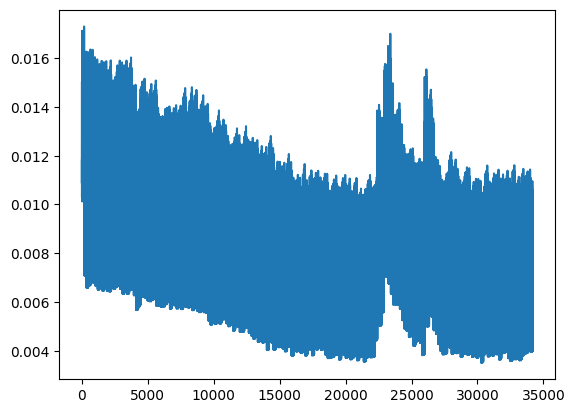

In [8]:
plt.plot(loss)
plt.xlabel('Total_number of epochs')
plt.ylabel('Validation loss')
plt.title('Validation loss during the training')

In [ ]:
#test_indices loss plot maybe or what can we do with that

In [20]:
n = 1234
predicted_angles2 = model.forward(embeddings[n,:,:], create_mask(indices = n))[:lengths[n],:]#embedding, tensor, what attention

#predicted_angles2
angles_new2 =predicted_angles2.T*(180/np.pi)
angles_new2

tensor([[-125.8454,  -61.1959,  -69.0457,  -92.5978,  -83.0996, -142.3836,
          -66.5183, -278.0284, -109.4707, -137.6073, -142.8075, -129.3386,
         -123.2382, -129.5319, -126.9766, -129.1886, -111.4707, -107.4088,
          -59.0542,  -56.3744,  -61.5057,  -64.4714,  -53.3250,  -54.5446,
          -54.2772,  -53.3738,  -59.8120,  -59.3016,  -65.9206, -254.5582,
         -107.3062, -149.6702,  -63.9217, -179.6466, -116.2629, -111.4171,
         -110.6395, -126.3758, -103.6537, -107.7972, -130.0090, -131.1954,
          -94.8827, -103.2172, -123.8517, -116.0330, -221.3050, -110.9984,
         -144.9092, -125.9520, -106.9340, -105.9883, -112.0375,  -99.3172,
         -256.4728, -109.6799, -108.3568, -125.9329, -144.6671, -138.7010,
         -147.6411,  -57.4565,  -68.4618,  -76.4842,  -61.0122,  -53.6465,
          -67.6708,  -76.6602, -106.5106, -119.0216, -129.0927, -127.1322,
         -109.3138, -128.7913,  -78.0982,  -84.5554, -164.4187, -300.0273,
          -62.0674],
    

In [21]:
torch.save(angles_new2 ,'predictions/full/predict_1234_02.pt' )

In [ ]:
angles

In [ ]:
# loading file
'''pdbl = PDBList()
cif_parser = MMCIFParser()
structure = cif_parser.get_structure("2fm4", r"C:\Users\sandr\OneDrive\Desktop\LCP_B project\PISCES data\extraction\small proteins\2fm4.cif") # getting structure
model0 = structure[0]

d3to1 = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
 'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
 'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
 'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

sequence = []
for residue in model0["A"]:
    # for simplicity we can use X for heteroatoms (ions and water)
    sequence.append(d3to1.get(residue.get_resname(), 'X'))  #converts water and ions to X
print(''.join(sequence))'''

In [ ]:

'''structure.atom_to_internal_coordinates() # turns xyz coordinates into angles and bond lengths

chain:PDB.Chain.Chain = list(structure[0].get_chains())[0]#iterator of chains, turns it into list, [0] first chain

ic_chain: PDB.internal_coords.IC_Chain = chain.internal_coord #this access the internal chain coords of the chain object
#if you modify this, you will modify the orgiginal

d: Dict[Tuple[PDB.internal_coords.AtomKey,
              PDB.internal_coords.AtomKey,
              PDB.internal_coords.AtomKey,
              PDB.internal_coords.AtomKey],
        PDB.internal_coords.Dihedron] = ic_chain.dihedra

cnt = 0
phi_angles = {}
psi_angles = {}

print(len(sequence))

for key in d:
    if key[0].akl[3] == 'N' and key[1].akl[3] == 'CA' and key[2].akl[3] == 'C' and key[3].akl[3] == 'N':

        d[key].angle = angles_new[ 1, cnt].item()
        print(angles_new[1,cnt].item())
    elif key[0].akl[3] == 'CA' and key[1].akl[3] == 'C' and key[2].akl[3] == 'N' and key[3].akl[3] == 'CA':
        d[key].angle = angles_new[ 0, cnt].item()
        #print("psi calcukated")
        print(cnt)
        cnt += 1


structure.internal_to_atom_coordinates(verbose = False)
io = PDBIO() #this is to write a pdb file again
io.set_structure(structure)#set structure, the structure you want in the pdb file
io.save('2fm4_pred.pdb',  preserve_atom_numbering=True) #saves to a file, filename you a , true - preserves the original atom numbering


'''

In [ ]:
'''print(PDB.internal_coords.Dihedron)'''